<a href="https://colab.research.google.com/github/jassatish/Body-Pose-Recognition/blob/main/body_Pose_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'body-pose-recognition:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1990304%2F3286821%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240711%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240711T153655Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D69df352235beea3135442065783bd4b630b9767249dc64432bd91fdcf35ac160d4724f80f001db27d86667c6968fa86144c7df3910ce5329fa0a2142146319b26c375c373e99a6c36b632cf537b8cf05c29663f7e88f8a940826268e7508d7f2b9efbddfb5bc9705b606f9a389c01909d97f5999fb5d6084c995baebca2e04ece7e7bca583c6171b3935217f30794ba713fb37b9d25bf9047f5ef11999f741eee41c10a8a59691b9405e920f35dd963e5b8716d5ba7f005893994ae68e8a9e3ea5da89c1fbca3c17ea4fb59279ec33ac486228fbec20a8fe4d92a7acf442790ff888c3a6fb59bc2a5aa4bcf557faa1f685f6dd179db8d6b5345399b522fa8eba'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 5290194 bytes downloaded
Downloaded and uncompressed: body-pose-recognition
Data source import complete.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import keras
import cv2
import os

# Import of keras model and hidden layers for our convolutional network
from tensorflow.keras.preprocessing import image
from keras.layers import Conv2D, Activation, MaxPool2D, Dense, Flatten, Dropout

for dirname, _, filenames in os.walk('/kaggle/input'):
        print(os.path.join(dirname))

/kaggle/input
/kaggle/input/body-pose-recognition
/kaggle/input/body-pose-recognition/Body_pose_classes
/kaggle/input/body-pose-recognition/Body_pose_classes/kick
/kaggle/input/body-pose-recognition/Body_pose_classes/stand
/kaggle/input/body-pose-recognition/Body_pose_classes/duck
/kaggle/input/body-pose-recognition/Body_pose_classes/jump
/kaggle/input/body-pose-recognition/Body_pose_classes/throw
/kaggle/input/body-pose-recognition/Body_pose_classes/punch
/kaggle/input/body-pose-recognition/Body_pose_classes/power


In [ ]:
dir = '/kaggle/input/body-pose-recognition/Body_pose_classes'

categories = ['stand' , 'duck', 'jump', 'punch', 'power','kick', 'throw']

In [ ]:
image_data= []
for dr in os.listdir(dir):
  class_index= categories.index(dr)
  path= os.path.join(dir, categories[class_index])
  for img in os.listdir(path):
    img_arr= cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
    image_data.append([img_arr, class_index])

image_data[0]

[array([[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]], dtype=uint8),
 5]

In [ ]:
len(image_data)

3500

In [ ]:
random.shuffle(image_data)

input_data = []
label = []
for X, y in image_data:
    input_data.append(X)
    label.append(y)

label[:10]

[4, 1, 4, 1, 6, 1, 1, 5, 6, 1]

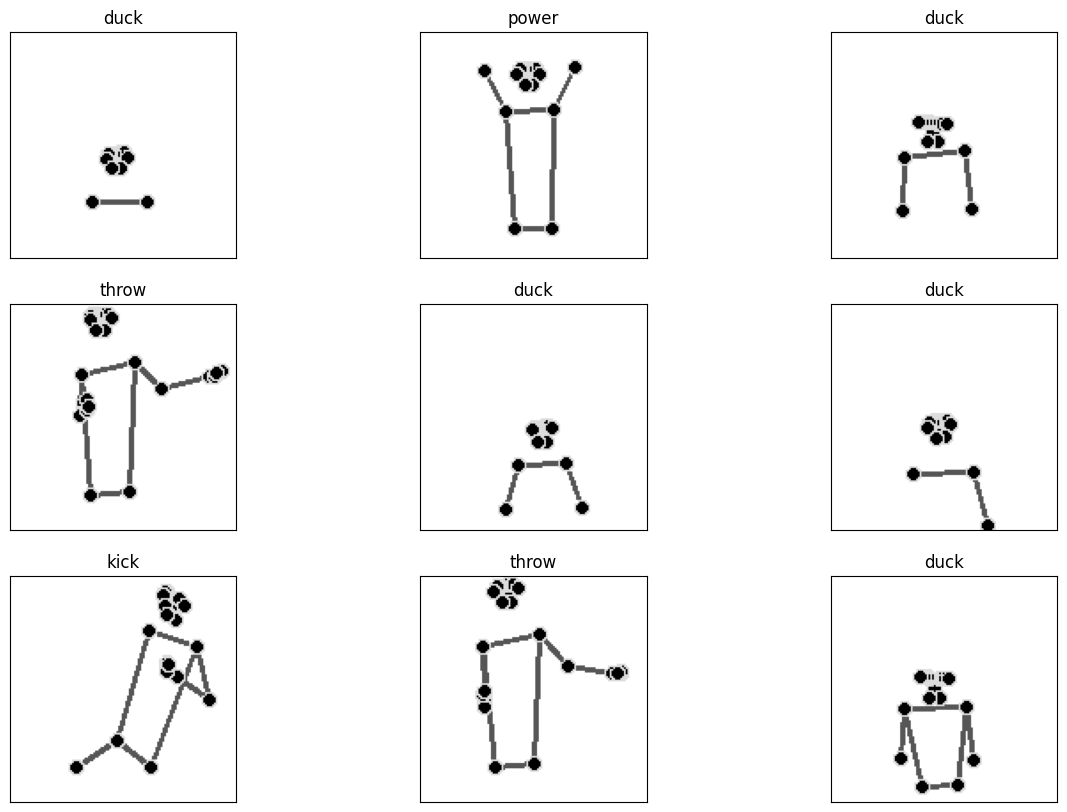

In [ ]:
plt.figure(1, figsize=(15,10))
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.imshow(image_data[i][0], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(categories[label[i]])
plt.show()

In [ ]:
input_data = np.array(input_data)
label = np.array(label)
input_data = input_data/255.0
input_data.shape

(3500, 128, 128)

In [ ]:
from keras.utils import to_categorical

# one hot encoding
label = to_categorical(label, num_classes=10, dtype='i1')
print(label[0])


[0 0 0 0 1 0 0 0 0 0]


In [ ]:
# reshaping the data
input_data.shape = (-1, 128, 128, 1)

# splitting the input_data to train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_data, label, test_size = 0.2, random_state=0)

X_train.shape

(2800, 128, 128, 1)

In [ ]:
model = keras.models.Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = (128, 128, 1)))
model.add(Activation('relu'))

model.add(Conv2D(filters = 32, kernel_size = (3,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, kernel_size = (3,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))


model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer = 'rmsprop',
             metrics = ['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs = 5, batch_size= 64, validation_split= 0.2)

Epoch 1/5
35/35 [==============================] - 136s 4s/step - loss: 1.2518 - accuracy: 0.7241 - val_loss: 0.0682 - val_accuracy: 0.9839
Epoch 2/5
35/35 [==============================] - 144s 4s/step - loss: 0.0408 - accuracy: 0.9893 - val_loss: 0.0561 - val_accuracy: 0.9786
Epoch 3/5
35/35 [==============================] - 135s 4s/step - loss: 0.0222 - accuracy: 0.9920 - val_loss: 0.0179 - val_accuracy: 0.9964
Epoch 4/5
35/35 [==============================] - 135s 4s/step - loss: 0.2053 - accuracy: 0.9763 - val_loss: 0.0311 - val_accuracy: 0.9911
Epoch 5/5
35/35 [==============================] - 133s 4s/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0206 - val_accuracy: 0.9946


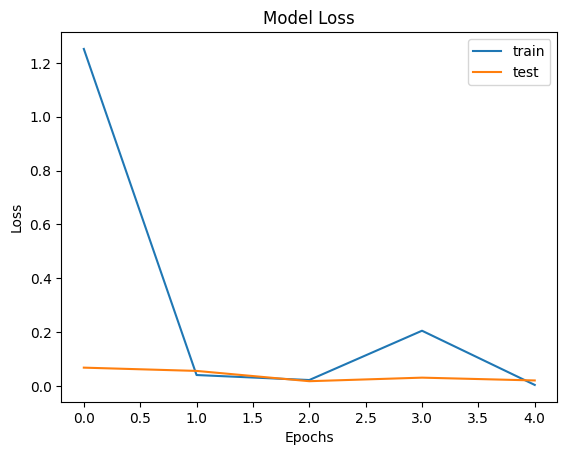

In [ ]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

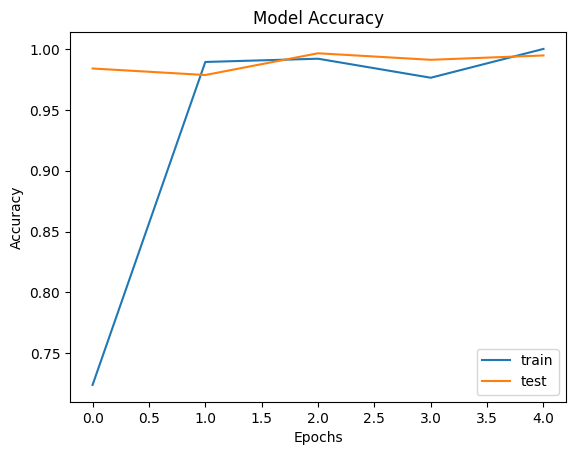

In [ ]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_accuracy*100))

22/22 [==============================] - 10s 466ms/step - loss: 0.0227 - accuracy: 0.9957
Test accuracy: 99.57%


22/22 [==============================] - 11s 476ms/step


[]

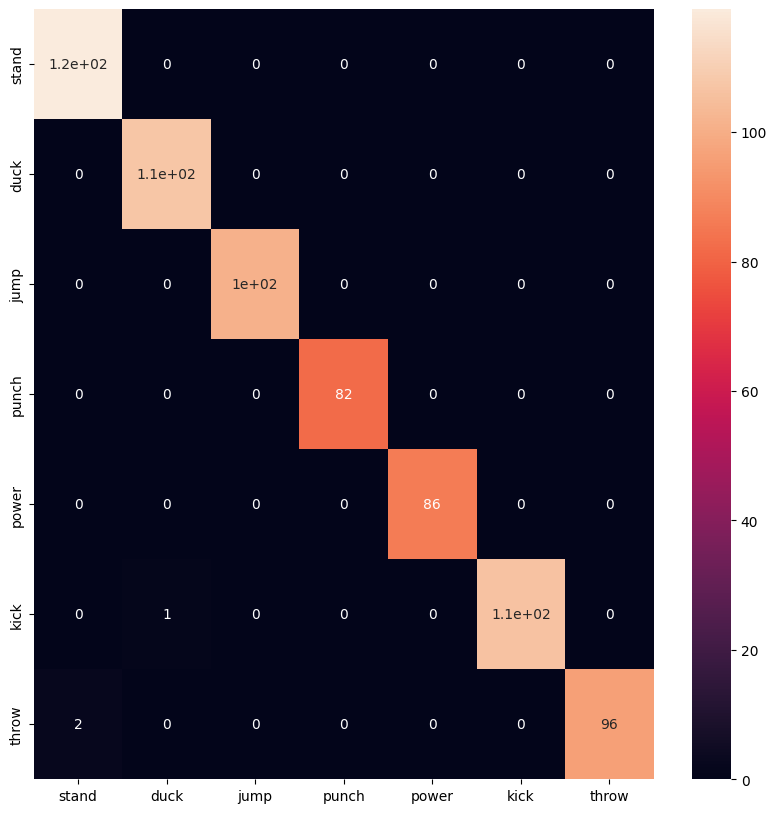

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
cat = [c for c in categories]
plt.figure(figsize=(10,10))
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
sn.heatmap(cm, annot=True,xticklabels=cat, yticklabels=cat)
plt.plot()